In [ ]:
!pip install ortools

In [ ]:
import networkx as nx
import random
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt

# Trabalho 2

Este trabalho foi realizado por:


*   João Pedro Goulart - A82643
*   Tiago Rodrigues - A87952

1. Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido.

> O grafo tem de ser ligado, o que significa que entre cada par de nodos $\langle n_1,n_2 \rangle$ tem de existir um caminho $n_1 \leadsto n_2$ e um caminho $n_2\leadsto n_1$.

a) Gerar aleatoriamente um tal grafo com  $N=32$ nodos.  Cada nodo tem um número aleatório de descendentes no intervalo $\,1..3\,$  cujos destinos são distintos entre si do nodo origem.

DiGraph with 32 nodes and 68 edges


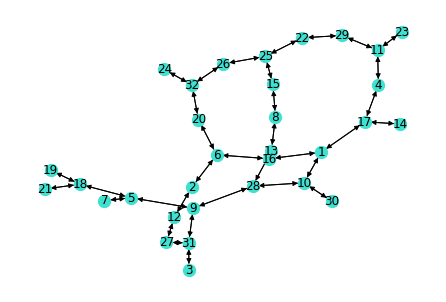

In [ ]:
def gera(n):
    l = []
    r = 0
    while (r == 0):
        l = []
        for i in range(1,n+1):
            l.append(random.randint(1,3))

        if nx.is_valid_degree_sequence_havel_hakimi(l):
            G = nx.random_degree_sequence_graph(l)
            G = nx.convert_node_labels_to_integers(G,first_label=1)

            if (nx.is_connected(G)==True):
                H = nx.DiGraph()
                H = G.to_directed()
                if(nx.is_strongly_connected(H)==True):
                  r = 1
                  return H

n =32
G=gera(n)
print(G)
nx.draw(G, with_labels = True,node_size=150,node_color='turquoise')

b) Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

# Desenvolvimento 

Temos como objetivo gerar um subgrafo 𝐻  de  𝐺 com o menor número possível de arestas pertencentes a G. Devemos manter o número de vértices.

Seja $E$ o conjunto de todas as arestas de $G$ e $C_{s,t}$ o conjunto de todos os caminhos simples entre $s$ e $t$

Com o auxílio do Or tools trataremos das seguintes condições:


1.   Para todos o caminhos de $G$ , se um dado caminho $c$ de origem no nodo $e_s$ e destino $e_t$ está presente no subgrafo, então todas a arestas desse caminho terão de existir no subgrafo:
$$\forall_{e<E} \cdot \forall_{c<C} \cdot \forall_{e'<c} ( d_{e'} \, \geq x_{e}) $$

2.   Para todas as arestas  $e\in E$ existe pelo menos um caminho de origem $e_s$ e destino $e_t$:

$$\forall_{e<E} \, \sum_{c<C}\, x_e \geq 1$$




Vamos, então, incluir as condições no nosso código:

Grafo fortemente conectado
DiGraph with 32 nodes and 43 edges


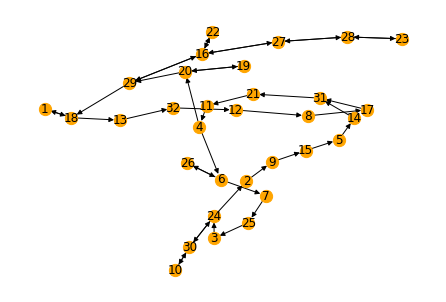

In [ ]:
def arestas(p): 
    return [(p[i],p[i+1]) for i in range(len(p)-1)]

def geraSub(graph): 
    sol = pywraplp.Solver.CreateSolver('CP-SAT')
    d = {}
    x = {} 
    for e in graph.edges(): # Variável por aresta
        d[e] = sol.BoolVar(str(e))
    

    for s in graph.nodes:
        for t in graph.nodes:
            
            if s!=t: # Para não haver arestas tais que origem = destino
              cam = list(nx.all_simple_paths(graph,s,t)) # lista de caminhos possíveis
              
              for i in range(len(cam)): # Adicionar variáveis
                x[i] = sol.BoolVar(str(i) + ',' + str(s)+ ',' + str(t))

                for e in arestas(cam[i]): # Arestas do cainho s,t
                  sol.Add(d[e]>=x[i])   # Primeira restrição 
              
              sol.Add(sum(x.values()) >= 1)  # Segunda restrição (somatório)
              x = {}


    # Minimizar o número de arestas necessárias

    sol.Minimize(sum(d.values()))
    assert(sol.Solve() == pywraplp.Solver.OPTIMAL)

    remover = [e for e in graph.edges() if round(d[e].solution_value()) == 0] # Lista com todas as arestas a remover

    H = G.copy() # Criar uma cópia do grafo original para não o alterar
    for (o,d) in G.edges():
      if (o,d) in remover:
        H.remove_edge(o,d) # Removemos as arestas selecionadas
    if nx.is_strongly_connected(H):
      print("Grafo fortemente conectado")
    return H


H = geraSub(G)
nx.draw(H, with_labels = True,node_size=150,node_color ='orange')
print(H)

In [ ]:
print("Existem, portanto, "+str(G.number_of_edges()-H.number_of_edges())+" arestas que podem ser eliminadas, correspondendo ao maior número possível de vias que podem ser eliminadas mantendo o grafo ligado.")

Existem, portanto, 25 arestas que podem ser eliminadas, correspondendo ao maior número possível de vias que podem ser eliminadas mantendo o grafo ligado.


2. Considere-se um circuito booleano $\,\mathcal{C}\,$ com $\,n\,$ “wires” de “input” e um único “wire” de output.


* O circuito é descrito num bi-grafo com uma classe de nodos representando “gates” e a segunda classe representando “wires”. 

* Cada nodo contém um campo val cujo conteúdo descreve a semântica desse nodo; para os “wires” o campo val  contém uma variável SCIP; para as “gates” o campo val  contém uma marca bo conjunto and, or,  xor e not,   que indica o tipo de “gate. 

* Com exceção de not , que é um operador unário, todas as restantes “gates” têm um número arbitrário de “inputs” e um único “output”.

* No grafo os arcos com origem numa determinada “gate”  têm destino nos “wires” que são “input” dessa “gate”. Cada “wire” que não é “input” é origem de um único arco que tem como destino a “gate” do qual esse “wire” é “output”.

a) Escreva um programa que, a partir do número $\,n\,$ de “inputs”  e de um parâmetro positivo $\,\gamma\ll 1\,$ como argumentos,  gere aleatoriamente circuitos com “gates” or, and e not  em que o número de and's é  $\,\gamma\ast\,$ (número total de nodos).

In [ ]:
def geracircuito(n,gama):
  # Caso em que o input gama é 1
  if (gama==1):
    ands = 0
    ors = 0 
    xors = 0
    nots = 0
  else:
    ands = random.randint(1,n)
    ors = random.randint(1,n)
    xors = random.randint(1,n)
    nots = random.randint(1,n)
  
  G = nx.DiGraph()


b) Escreva um programa Python que leia um circuito arbitrário descrito pelo bi-grafo anterior e formule as restrições (em Programação Inteira) que descrevem as várias “gates” do circuito.

Para o código requisitado necessitamos, primeiramente, de formular as restrições. Para tal, estudámos os casos possíveis, ie. o caso de se tratar de um and, um not, um or e um xor. Consideremos, para o efeito, x um nodo 



1.   Se x é um and


1.   Se x é um not então a lista que contém os nodos aos quais x se encontra ligado possui apenas um elemento


2.   Se x é um or


2.   Se x é um xor




In [ ]:
def adrestricao(G):
  # A função recebe como input o bi-grafo G definido em a)
  

c) Usando os dois programas anteriores e o sistema SCIP, 

        i. Escreva um programa que determine um vetor de “inputs” $\x\in\{0,1\}^n\$ aceite pelo circuito (i.e. o respetivo output é $1$).
        ii. Determine o vetor $x'\neq x$ , também aceite pelo circuito, que está mais próximo de $x$. 

i)

In [ ]:
def vetoraceite(G):

  sol = pywraplp.Solver.CreateSolver('SCIP')

ii)

In [ ]:
def vetormaisprox(G):

  sol = pywraplp.Solver.CreateSolver('SCIP')